In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os

train_csv= pd.read_csv('/content/drive/MyDrive/1327317/training_set_pixel_size_and_HC.csv')
test_csv= pd.read_csv('/content/drive/MyDrive/1327317/test_set_pixel_size.csv')
print(train_csv.head())
print("------------------------------")
print(test_csv.head())


     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81
------------------------------
     filename  pixel size(mm)
0  000_HC.png        0.235857
1  001_HC.png        0.067973
2  002_HC.png        0.165202
3  003_HC.png        0.096674
4  004_HC.png        0.202203


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(f"TensorFlow version: {tf.__version__}")
print(f"Devices: {tf.config.list_physical_devices()}")


TensorFlow version: 2.19.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

BASE_DIR = '/content/drive/MyDrive/1327317'
TRAIN_DIR = os.path.join(BASE_DIR, 'training_set')
TEST_DIR = os.path.join(BASE_DIR, 'test_set')
TRAIN_CSV = os.path.join(BASE_DIR, 'training_set_pixel_size_and_HC.csv')
TEST_CSV = os.path.join(BASE_DIR, 'test_set_pixel_size.csv')


IMG_SIZE = (224, 224)
EPOCHS = 50
BATCH_SIZE = 16


print(f"Train dir exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test dir exists: {os.path.exists(TEST_DIR)}")
print(f"Train CSV exists: {os.path.exists(TRAIN_CSV)}")
print(f"Test CSV exists: {os.path.exists(TEST_CSV)}")


train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"\nTrain samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("\nTrain data:")
print(train_df.head())


Train dir exists: True
Test dir exists: True
Train CSV exists: True
Test CSV exists: True

Train samples: 999
Test samples: 335

Train data:
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81


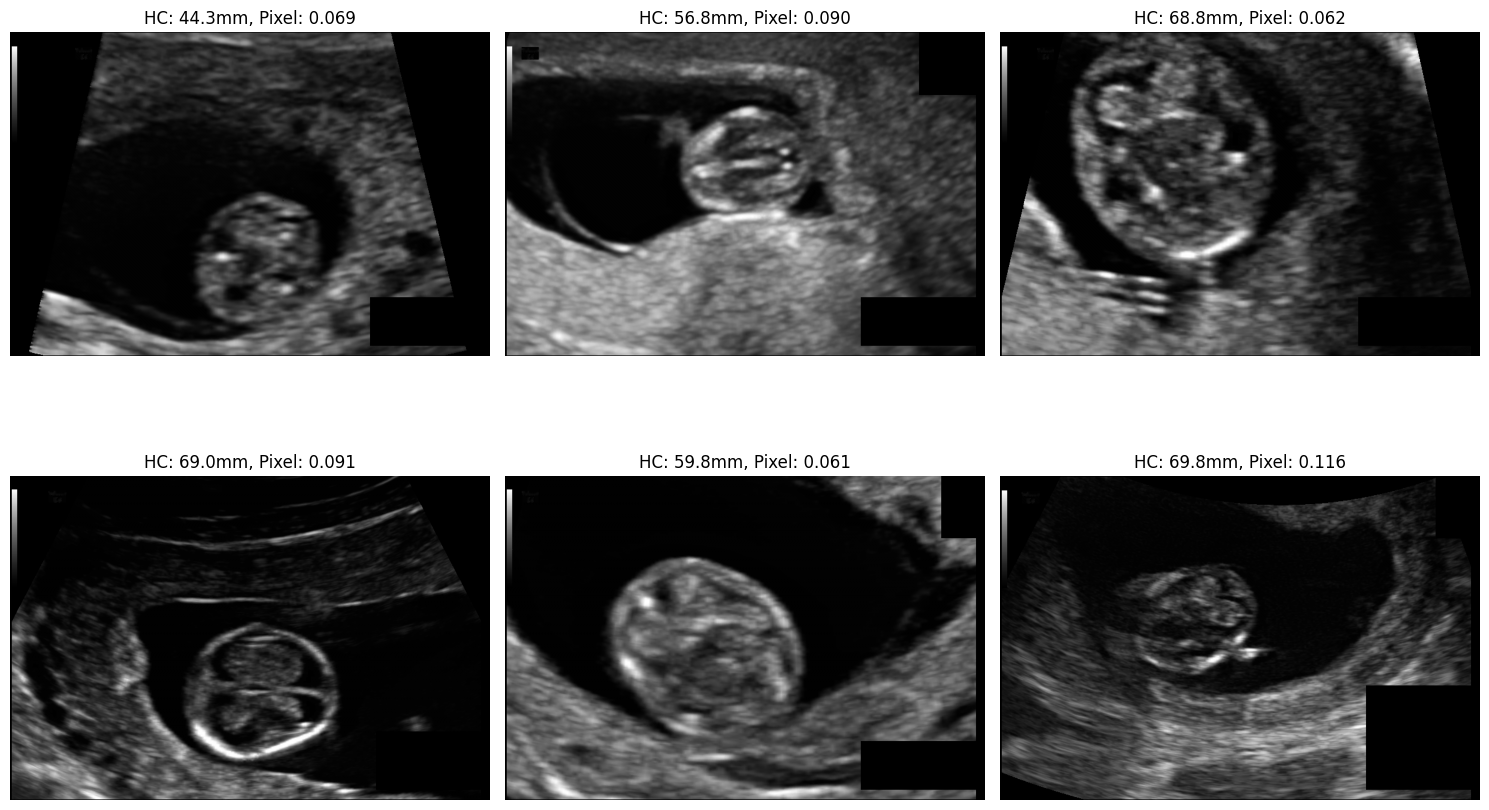

In [ ]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    if i < len(train_df):
        filename = train_df.iloc[i]['filename']
        img_path = os.path.join(TRAIN_DIR, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        hc = train_df.iloc[i]['head circumference (mm)']
        pixel_size = train_df.iloc[i]['pixel size(mm)']

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'HC: {hc:.1f}mm, Pixel: {pixel_size:.3f}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:


import math

def extract_ellipse_axes(annotation_path):
    ann = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    _, ann = cv2.threshold(ann, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        ann, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    if len(contours) == 0:
        raise ValueError("No contour found")

    cnt = max(contours, key=cv2.contourArea)
    (_, _), (w, h), _ = cv2.fitEllipse(cnt)

    return w / 2, h / 2
def load_data(df, data_dir, img_size):
    X_images = []
    X_pixel_sizes = []
    y = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        fname = row['filename']

        img_path = os.path.join(data_dir, fname)
        ann_path = os.path.join(
            data_dir,
            fname.replace(".png", "_Annotation.png")
        )

        if not os.path.exists(img_path) or not os.path.exists(ann_path):
            continue


        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)


        a, b = extract_ellipse_axes(ann_path)

        X_images.append(img)
        X_pixel_sizes.append(row['pixel size(mm)'])
        y.append([a, b])

    return (
        np.array(X_images),
        np.array(X_pixel_sizes).reshape(-1, 1),
        np.array(y)
    )

def load_test_data(df, data_dir, img_size):
    X_images = []
    X_pixel_sizes = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        fname = row['filename']
        img_path = os.path.join(data_dir, fname)

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        X_images.append(img)
        X_pixel_sizes.append(row['pixel size(mm)'])

    return (
        np.array(X_images),
        np.array(X_pixel_sizes).reshape(-1, 1)
    )



print("Loading training data...")
X_img, X_pixel, y = load_data(train_df, TRAIN_DIR, IMG_SIZE)

print(f"\nImages shape: {X_img.shape}")
print(f"Pixel sizes shape: {X_pixel.shape}")
print(f"Targets shape: {y.shape}")
print(f"HC range: [{y.min():.2f}, {y.max():.2f}] px")


indices = np.arange(len(X_img))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train = [X_img[train_idx], X_pixel[train_idx]]
X_val = [X_img[val_idx], X_pixel[val_idx]]
y_train = y[train_idx]
y_val = y[val_idx]

print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}")


Loading training data...


100%|██████████| 999/999 [00:16<00:00, 60.43it/s]



Images shape: (999, 224, 224, 1)
Pixel sizes shape: (999, 1)
Targets shape: (999, 2)
HC range: [64.73, 332.55] px

Train: 799, Val: 200


In [ ]:
def build_model(img_size=(224, 224)):
    img_input = layers.Input(shape=(*img_size, 1))

    x = layers.Conv2D(3, (1, 1), padding='same')(img_input)

    backbone = EfficientNetB0(
        include_top=False,
        weights=None,
        input_tensor=x,
        pooling='avg'
    )

    x = backbone.output
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    output = layers.Dense(2, activation='linear')(x)  # a, b

    return models.Model(img_input, output)



In [ ]:

model = build_model(IMG_SIZE)

model.compile(
    optimizer='adam',
    loss='mae'
)

callbacks = [
    EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True, mode='min'),
    ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-7, mode='min')
]


history = model.fit(
    X_train[0],
    y_train,
    validation_data=(X_val[0], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - loss: 164.4189 - val_loss: 156.3895 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - loss: 53.0051 - val_loss: 59.8651 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 41.4110 - val_loss: 34.8297 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 41.5661 - val_loss: 34.5332 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 40.8980 - val_loss: 61.0905 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 36.6514 - val_loss: 47.7500 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 38.0632 - val_loss: 33.7464 - learning_rate: 0.0010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 34.9946 - val_loss: 42.9902 - learning_rate: 0.0010
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 33.3429 - val_loss: 46.2592 - learning_rate: 0.001

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
 DL EVALUATION (Ellipse-supervised, unit = mm)
MAE:  9.3358 mm 
RMSE: 14.2837 mm
R²:   0.9498


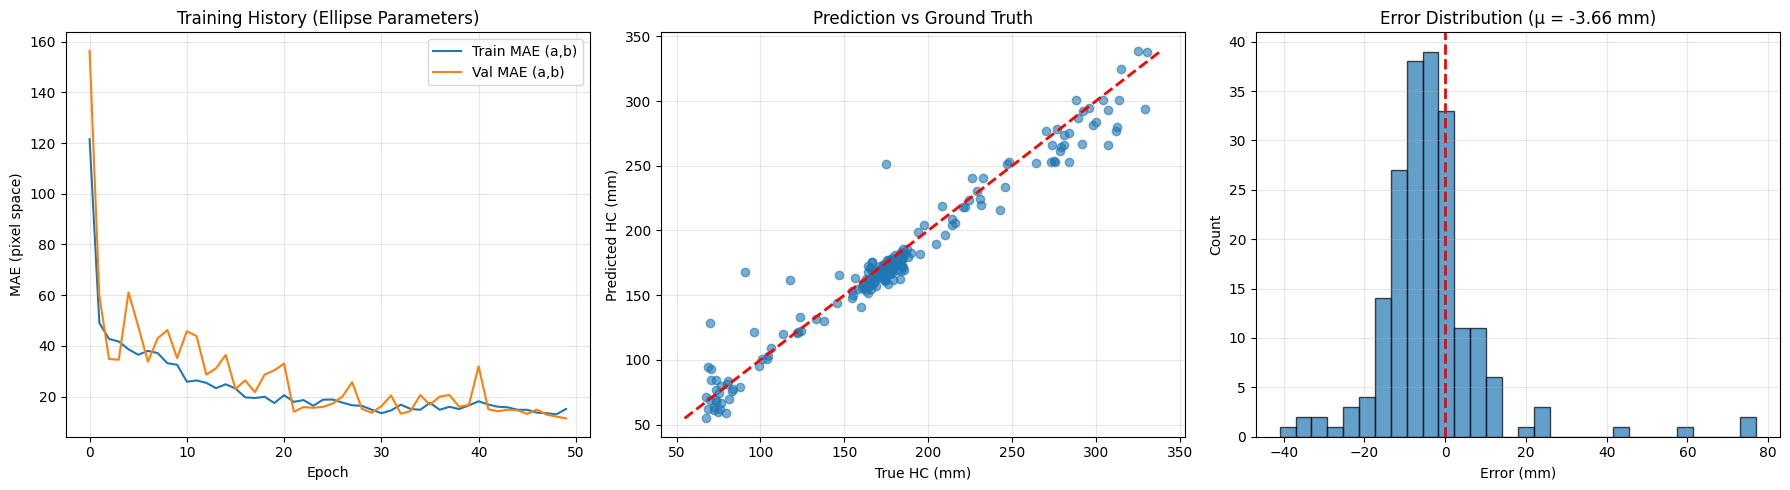

In [ ]:


import math

def ellipse_perimeter(a, b):
    return math.pi * (3*(a + b) - np.sqrt((3*a + b)*(a + 3*b)))




pred_ab = model.predict(X_val[0])
a_pred, b_pred = pred_ab[:, 0], pred_ab[:, 1]


a_gt, b_gt = y_val[:, 0], y_val[:, 1]




hc_pred_pixel = ellipse_perimeter(a_pred, b_pred)
hc_gt_pixel   = ellipse_perimeter(a_gt, b_gt)

pixel_sizes_val = X_pixel[val_idx].flatten()

hc_pred_mm = hc_pred_pixel * pixel_sizes_val
hc_gt_mm   = hc_gt_pixel * pixel_sizes_val



mae  = mean_absolute_error(hc_gt_mm, hc_pred_mm)
rmse = np.sqrt(np.mean((hc_gt_mm - hc_pred_mm) ** 2))
r2   = 1 - np.sum((hc_gt_mm - hc_pred_mm) ** 2) / np.sum((hc_gt_mm - hc_gt_mm.mean()) ** 2)


print(" DL EVALUATION (Ellipse-supervised, unit = mm)")
print(f"MAE:  {mae:.4f} mm ")
print(f"RMSE: {rmse:.4f} mm")
print(f"R²:   {r2:.4f}")




fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].plot(history.history['loss'], label='Train MAE (a,b)')
axes[0].plot(history.history['val_loss'], label='Val MAE (a,b)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE (pixel space)')
axes[0].set_title('Training History (Ellipse Parameters)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].scatter(hc_gt_mm, hc_pred_mm, alpha=0.6)
min_val = min(hc_gt_mm.min(), hc_pred_mm.min())
max_val = max(hc_gt_mm.max(), hc_pred_mm.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1].set_xlabel('True HC (mm)')
axes[1].set_ylabel('Predicted HC (mm)')
axes[1].set_title('Prediction vs Ground Truth')
axes[1].grid(True, alpha=0.3)


errors = hc_pred_mm - hc_gt_mm
axes[2].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Error (mm)')
axes[2].set_ylabel('Count')
axes[2].set_title(f'Error Distribution (μ = {errors.mean():.2f} mm)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
X_test_img, X_test_pixel = load_test_data(test_df, TEST_DIR, IMG_SIZE)


pred_ab = model.predict(X_test_img)
a_pred, b_pred = pred_ab[:,0], pred_ab[:,1]

hc_pixel = ellipse_perimeter(a_pred, b_pred)
hc_mm = hc_pixel * X_test_pixel.flatten()

results = pd.DataFrame({
    'filename': test_df['filename'][:len(hc_mm)],
    'predicted_HC_mm': hc_mm
})

results.to_csv("test_predictions_dl_ellipse.csv", index=False)
print(results.head())


100%|██████████| 335/335 [00:03<00:00, 89.44it/s] 


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 416ms/step
     filename  predicted_HC_mm
0  000_HC.png       270.791723
1  001_HC.png        74.935219
2  002_HC.png       204.885005
3  003_HC.png       163.950402
4  004_HC.png       315.336718


In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

TRAIN_DIR = "/content/drive/MyDrive/1327317/training_set"
TRAIN_CSV = "/content/drive/MyDrive/1327317/training_set_pixel_size_and_HC.csv"

df = pd.read_csv(TRAIN_CSV)

y_true = []
y_pred = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    fname = row['filename']
    pixel_size = row['pixel size(mm)']
    hc_gt = row['head circumference (mm)']


    ann_path = os.path.join(
        TRAIN_DIR,
        fname.replace(".png", "_Annotation.png")
    )

    hc_pixel = compute_hc_from_annotation(ann_path)
    hc_mm = hc_pixel * pixel_size

    y_true.append(hc_gt)
    y_pred.append(hc_mm)

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE (mm): {mae:.4f}")


100%|██████████| 999/999 [06:04<00:00,  2.74it/s]

MAE (mm): 0.7135
